# <center>Classifier guidance</center>

In [1]:
import torch
from torchvision import utils
from matplotlib import pyplot as plt
from diffusers import DDPMPipeline, DDIMScheduler

torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Device: {device}.')

Device: cuda.


## DDPM pre-entrenado usando DDIM

In [ ]:
checkpoint = 'google/ddpm-celebahq-256'
n_steps = 60

# Pipeline:
ddpm_pipeline = DDPMPipeline.from_pretrained(checkpoint)
ddpm_pipeline.to(device)

# Scheduler DDIM:
ddim_scheduler = DDIMScheduler.from_pretrained(checkpoint)
ddim_scheduler.set_timesteps(n_steps)

In [9]:
def show_denoising(step, total_steps, t, *images):
    fig, axs = plt.subplots(1, 2, figsize=(6, 2))
    titles = 'paso', 'predicción'

    for ax, img, title in zip(axs, images, titles):
        grid = utils.make_grid(img).clip(-1, 1)
        ax.imshow(grid.cpu().permute(1, 2, 0) * 0.5 + 0.5)
        ax.axis('off')
        ax.set_title(title + ' actual')

    fig.suptitle(f'Scheduler step: {step}/{total_steps} | Tiempo de la cadena: {t}')
    plt.tight_layout()
    plt.show()

def generate_samples(pipeline, scheduler, n_samples=2, resolution=(256, 256)):
    x = torch.randn(n_samples, 3, *resolution, device=device)

    with torch.no_grad():
        for step, t in enumerate(scheduler.timesteps, 1):

            x = scheduler.scale_model_input(x, t)
            noise_prediction = pipeline.unet(x, t)['sample']
            scheduler_output = scheduler.step(noise_prediction, t, x)
            x = scheduler_output['prev_sample']

            if step % 20 == 0:
                current_prediction = scheduler_output['pred_original_sample']
                show_denoising(step, len(scheduler.timesteps), t, x, current_prediction)
    return x

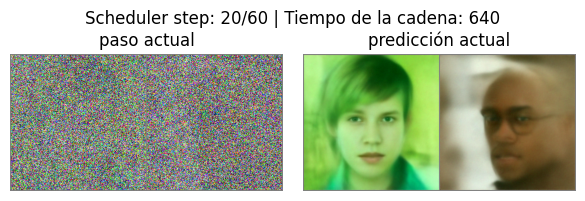

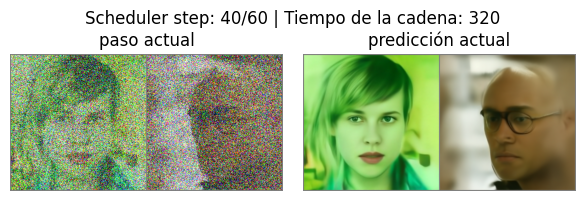

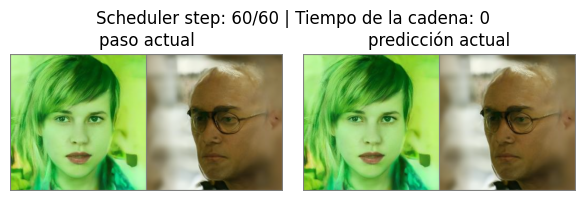

In [10]:
sample_images = generate_samples(ddpm_pipeline, ddim_scheduler)

## Classifier guidance

Dada una distribución $c\sim p(c)$ interpretada como posibles condiciones sobre los elementos de un proceso de difusión $(x_t)_{t=1}^T$, se puede descomponer el score de un modelo generativo condicional $p(x_t|c)$ en una parte asociada a un modelo generativo incondicional $p(x_t)$ y otra asociada a un modelo discriminativo $p(c|x_t)$ mediante la fórmula de Bayes:

$$
\nabla_{x_t}\log p(x_t|c) = \nabla_{x_t}\log \left(\frac{p(c|x_t)p(x_t)}{p(c)}\right) = \nabla_{x_t}\log p(c|x_t) + \nabla_{x_t}\log p(x_t) - \nabla_{x_t}\log p(c) = \nabla_{x_t}\log p(c|x_t) + \nabla_{x_t}\log p(x_t)
$$

Para `guidance` se penalizará la desviación absoluta media entre los pixeles de la imagen original y una imagen con todos sus pixeles color carmín. Si bien este criterio no representa una medida de probabilidad ya que no integra 1, esto no afectará en la práctica ya que el score es invariante bajo constantes multiplicativas.

In [5]:
def color_loss(images, target_color=(1.0, 0.34, 0.2)):
    scaled_target = torch.tensor(target_color, device=images.device) * 2 - 1
    error = torch.abs(images - scaled_target.view(1, -1, 1, 1))
    return error.mean()

In [6]:
def guidance_sampling(pipeline, scheduler, n_samples=5, resolution=(256, 256), loss_fn=color_loss, guidance_scale=13):

    x = torch.randn(n_samples, 3, *resolution, device=device)

    for t in scheduler.timesteps:

        x = x.detach().requires_grad_()

        model_input = scheduler.scale_model_input(x, t)
        with torch.no_grad():
            noise_pred = pipeline.unet(model_input, t)['sample']
        scheduler_output = scheduler.step(noise_pred, t, x)

        x0_prediction = scheduler_output['pred_original_sample']

        loss = loss_fn(x0_prediction) * guidance_scale
        grad = torch.autograd.grad(loss, x)[0]
        x = x - grad
        x = scheduler.step(noise_pred, t, x - grad)['prev_sample']

    return x

In [7]:
def show_guidance(pipeline, scheduler, guidance_scales):
    fig, axes = plt.subplots(len(guidance_scales), 1, figsize=(10, 2*len(guidance_scales)))

    for idx, guidance_scale in enumerate(guidance_scales):
        images = guidance_sampling(pipeline, scheduler, guidance_scale=guidance_scale)
        images = utils.make_grid(images).clip(-1, 1) * 0.5 + 0.5
        images = images.detach().cpu().permute(1, 2, 0)

        axes[idx].imshow(images)
        axes[idx].axis('off')
        axes[idx].set_title(f'Escala: {guidance_scale}')

    plt.tight_layout()
    plt.savefig('images/dm/guidance.pdf', bbox_inches='tight')
    plt.show()

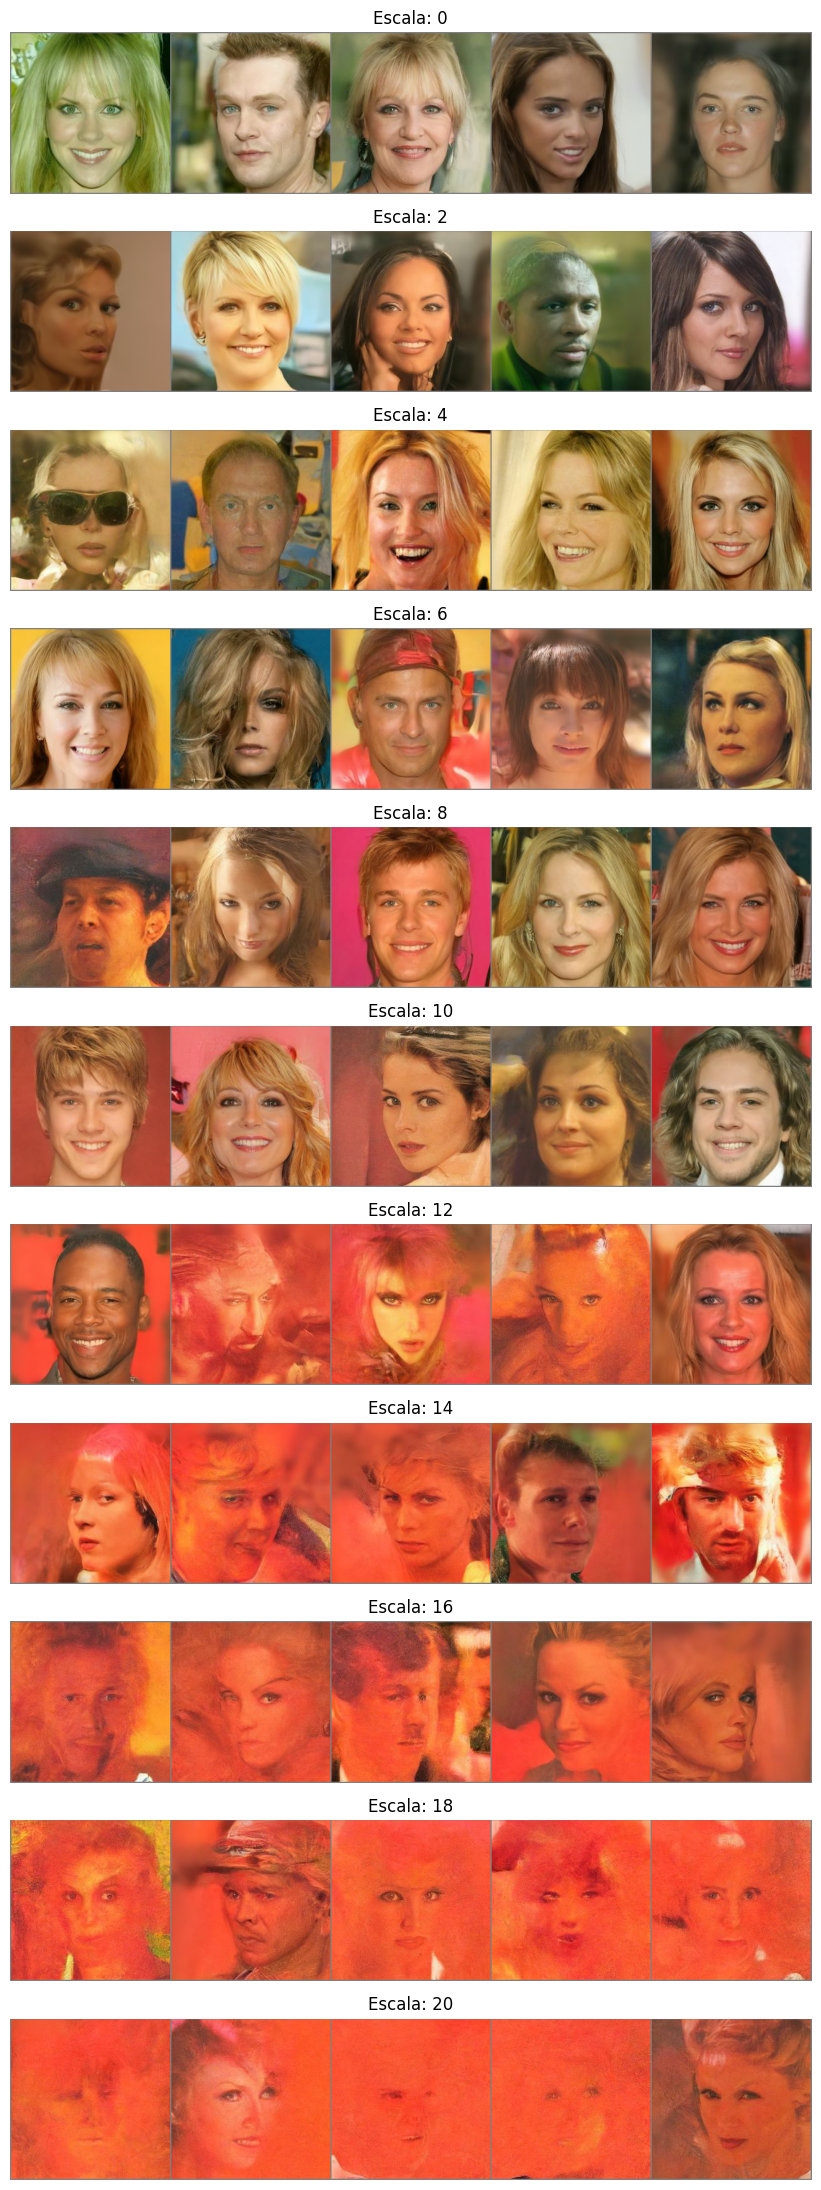

In [8]:
guidance_scales = [2*i for i in range(11)]
show_guidance(ddpm_pipeline, ddim_scheduler, guidance_scales)